In [ ]:
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

from build.autoneuronet import (
    Var,
    Matrix,
    Linear,
    ReLU,
    Softmax,
    NeuralNetwork,
    GradientDescentOptimizer,
    CrossEntropyLoss,
)

# MNIST Classification


In [9]:
train_dataset = datasets.MNIST("./data", train=True, download=True)
test_dataset = datasets.MNIST("./data", train=False)

batch_size = 16

In [3]:
train_images = train_dataset.data.numpy()
train_images = train_images.reshape(train_images.shape[0], -1)

train_labels = train_dataset.targets.numpy()

test_images = test_dataset.data.numpy()
test_images = test_images.reshape(test_images.shape[0], -1)

test_labels = test_dataset.targets.numpy()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 784), (60000,), (10000, 784), (10000,))

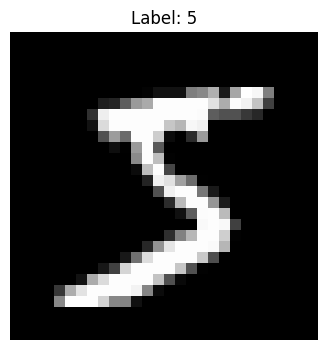

In [4]:
plt.figure(figsize=(4, 4))
plt.imshow(train_images[0].reshape(28, 28), cmap="gray")
plt.title(f"Label: {train_labels[0]}")
plt.axis(False)
plt.show()

In [11]:
def batch_generator(numpy_array: np.ndarray, batch_size: int = 16):
    num_samples = numpy_array.shape[0]
    for i in range(0, num_samples, batch_size):
        yield numpy_array[i : i + batch_size]

In [12]:
def numpy_to_matrix(numpy_array: np.ndarray) -> Matrix:
    numpy_array = np.asarray(numpy_array, dtype=float)

    if numpy_array.ndim == 1:
        numpy_array = numpy_array.reshape(-1, 1)
    elif numpy_array.ndim != 2:
        raise ValueError("Please pass in a 1D or 2D array")

    rows, cols = numpy_array.shape
    matrix = Matrix(rows, cols)

    for i in range(rows):
        for j in range(cols):
            matrix[i, j] = numpy_array[i, j]

    return matrix

In [13]:
train_images_matrices = []
train_labels_matrices = []

test_images_matrices = []
test_labels_matrices = []

for batch in batch_generator(train_images, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    train_images_matrices.append(batch_matrix)

for batch in batch_generator(train_labels, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    train_labels_matrices.append(batch_matrix)

for batch in batch_generator(test_images, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    test_images_matrices.append(batch_matrix)

for batch in batch_generator(test_labels, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    test_labels_matrices.append(batch_matrix)

In [ ]:
# train_images_matrix = numpy_to_matrix(train_images)
# train_labels_matrix = numpy_to_matrix(train_labels)

# test_images_matrix = numpy_to_matrix(test_images)
# test_labels_matrix = numpy_to_matrix(test_labels)

In [22]:
lr = 1e-2
epochs = 20

model = NeuralNetwork(
    [
        Linear(784, 128, init="he"),
        ReLU(),
        # Linear(256, 128, init="he"),
        # ReLU(),
        Linear(128, 10, init="he"),
        Softmax(),
    ]
)
optimizer = GradientDescentOptimizer(learning_rate=lr, model=model)

model

NeuralNetwork =
Linear(784, 128)
ReLU()
Linear(128, 10)
Softmax()

In [ ]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training the MNIST Neural Network"):
    train_loss = 0.0
    num_train_batches = 0

    training_pbar = tqdm(
        zip(train_images_matrices, train_labels_matrices),
        total=min(
            len(train_images_matrices),
            len(train_labels_matrices),
        ),
        desc=f"Training MNIST Neural Network {epoch + 1}",
    )

    for batched_images_matrix, batched_labels_matrix in training_pbar:
        optimizer.resetGrad()

        # Forward pass
        y_pred = model.forward(batched_images_matrix)

        # Calculate the loss
        loss = CrossEntropyLoss(batched_labels_matrix, y_pred)
        loss_val = loss.getVal()
        train_loss += loss_val

        training_pbar.set_postfix(
            loss=f"{loss_val:.8f}",
        )

        # Backpropagation
        loss.setGrad(1.0)
        loss.backward()
        optimizer.optimize()

        num_train_batches += 1

    print(f"Epoch: {epoch + 1} | Train Loss: {loss_val / num_train_batches}")

    os.makedirs("models/mnist", exist_ok=True)
    model.saveWeights(f"models/mnist/mnist_model_epoch_{epoch}.bin")

Training the MNIST Neural Network:   0%|          | 0/20 [00:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Testing Loop

test_loss = 0.0
num_test_batches = 0

testing_pbar = tqdm(
    zip(test_images_matrices, test_labels_matrices),
    total=min(
        len(test_images_matrices),
        len(test_labels_matrices),
    ),
    desc=f"Testing MNIST Neural Network {epoch + 1}",
)

for batched_images_matrix, batched_labels_matrix in testing_pbar:
    # Forward pass
    y_pred = model.forward(batched_images_matrix)

    # Calculate the loss
    test_loss = CrossEntropyLoss(batched_labels_matrix, y_pred)
    test_loss_val = test_loss.getVal()
    test_loss += test_loss_val

    testing_pbar.set_postfix(
        loss=f"{test_loss_val:.8f}",
    )

    num_test_batches += 1

print(f"Test Loss: {test_loss_val / num_test_batches}")